In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import keras 
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2,ResNet50,VGG19
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import cv2
import os
import argparse
from imutils import paths
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
basemodel = MobileNetV2(weights="imagenet",include_top= False, input_tensor =Input(shape=(224,224,3)))
x = basemodel.output
x = AveragePooling2D(pool_size=(7,7))(x)
x = Flatten()(x)
x = Dense(128,activation = "relu")(x)
x = Dropout(0.6)(x)
x = Dense(2, activation = "softmax")(x)
model = Model(inputs=basemodel.input,outputs=x)

In [4]:
for layer in basemodel.layers:
  layer.trainable = False

In [5]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [6]:
model.compile(loss="binary_crossentropy",optimizer="Adam",metrics=['accuracy'])

In [7]:
batch_size  = 32
epochs = 20

In [8]:
path = '/content/drive/My Drive/Finalproject/dataset/'
imagePaths = list(paths.list_images(path))
images = []
labels = []
for imagePath in imagePaths:
	      label = imagePath.split(os.path.sep)[-2]
	      image = load_img(imagePath, target_size=(224, 224))
	      image = img_to_array(image)
	      image = preprocess_input(image)
	      images.append(image)
	      labels.append(label)
images = np.array(images)
labels = np.array(labels)

In [9]:
print(images.shape)
print(labels.shape)

(1376, 224, 224, 3)
(1376,)


In [10]:
np.unique(labels)

array(['with_mask', 'without_mask'], dtype='<U12')

In [11]:
encoder = LabelBinarizer()
labels = encoder.fit_transform(labels)
labels = to_categorical(labels)

In [12]:
x_train , x_test ,y_train,y_test = train_test_split(images, labels, test_size=0.20,random_state=7,stratify=labels)

In [13]:
datagen = ImageDataGenerator(rotation_range =20,
                             zoom_range=0.20,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range = 0.2,
                             horizontal_flip =True,
                             fill_mode = "nearest")

In [14]:
ear = model.fit(datagen.flow(x_train,y_train,batch_size=batch_size),
                steps_per_epoch = len(x_train) // batch_size,
                validation_data = (x_test,y_test),
                validation_steps = len(x_test) // batch_size,
                epochs = epochs)

Epoch 1/20
34/34 [==============================] - 14s 422ms/step - loss: 0.1481 - accuracy: 0.9401 - val_loss: 0.0139 - val_accuracy: 0.9928
Epoch 2/20
34/34 [==============================] - 12s 367ms/step - loss: 0.0348 - accuracy: 0.9897 - val_loss: 0.0110 - val_accuracy: 0.9928
Epoch 3/20
34/34 [==============================] - 12s 367ms/step - loss: 0.0332 - accuracy: 0.9897 - val_loss: 0.0072 - val_accuracy: 0.9964
Epoch 4/20
34/34 [==============================] - 12s 365ms/step - loss: 0.0167 - accuracy: 0.9934 - val_loss: 0.0084 - val_accuracy: 0.9964
Epoch 5/20
34/34 [==============================] - 13s 371ms/step - loss: 0.0314 - accuracy: 0.9906 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 6/20
34/34 [==============================] - 13s 370ms/step - loss: 0.0165 - accuracy: 0.9934 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 7/20
34/34 [==============================] - 12s 362ms/step - loss: 0.0180 - accuracy: 0.9934 - val_loss: 0.0089 - val_accuracy: 0.9928

In [15]:
y_pred = model.predict(x_test,batch_size = batch_size)
y_pred = np.argmax(y_pred , axis =1)
print(classification_report(y_test.argmax(axis=1),y_pred,target_names=encoder.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      1.00      1.00       138
without_mask       1.00      0.99      1.00       138

    accuracy                           1.00       276
   macro avg       1.00      1.00      1.00       276
weighted avg       1.00      1.00      1.00       276



In [16]:
model.save("model",save_format="h5")

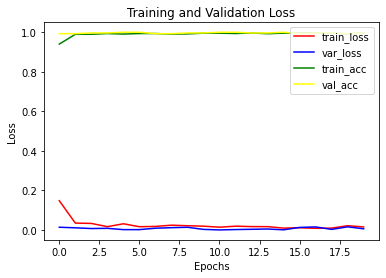

In [17]:
plt.plot(np.arange(0,epochs), ear.history['loss'],label='train_loss',color="red")
plt.plot(np.arange(0,epochs), ear.history['val_loss'],label='var_loss',color="blue")
plt.plot(np.arange(0,epochs), ear.history["accuracy"],label="train_acc",color="green")
plt.plot(np.arange(0,epochs),ear.history["val_accuracy"],label="val_acc",color="yellow")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc = "upper right")
plt.show()

In [18]:
prototxtPath = "/content/drive/My Drive/Finalproject/deploy.prototxt"
weightsPath  = "/content/drive/My Drive/Finalproject/res10_300x300_ssd_iter_140000.caffemodel"
face_model = cv2.dnn.readNet(prototxtPath,weightsPath)
model = load_model("model")

In [19]:
image = cv2.imread("/content/drive/My Drive/Finalproject/test/mine.jpg")
height,width = image.shape[:2]
blob = cv2.dnn.blobFromImage(image,1.0,(300,300),(104.0, 177.0 , 123))
face_model.setInput(blob)
detections = face_model.forward()

Number of person with mask : 3
Number of person without mask : 7


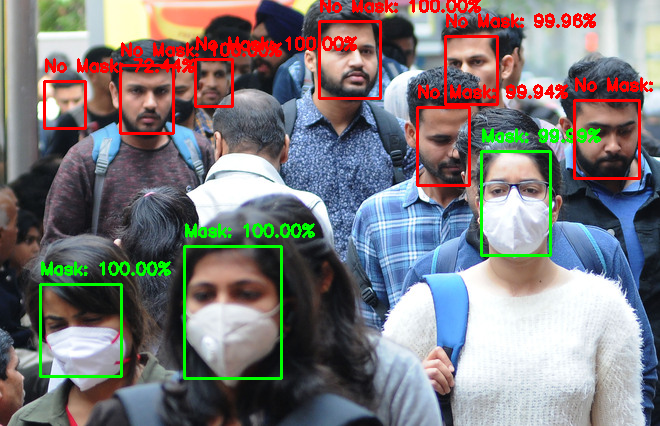

In [20]:
from google.colab.patches import cv2_imshow
threshold = 0.2
person_with_mask =0;
person_without_mask =0;
for i in range(0, detections.shape[2]):
  score = detections[0,0,i,2]
  if score > threshold:
    box = detections[0,0,i,3:7] * np.array([width,height,width,height])
    x_start, y_start, x_end, y_end = box.astype("int")
    x_start, y_start = (max(0, x_start), max(0, y_start))
    x_end, y_end = (min(width -1, x_end), min(height -1, y_end))

    face = image[y_start:y_end, x_start:x_end]
    face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    face = cv2.resize(face,(224,224))
    face = img_to_array(face)
    face = preprocess_input(face)
    face = np.expand_dims(face, axis=0)

    mask, withoutMask = model.predict(face)[0]

    if mask > withoutMask:
      label = "Mask"
      person_with_mask +=1
    else:
      label = "No Mask"
      person_without_mask +=1
    
    if label == "Mask":
      color = (0,255,0)
    else:
      color = (0,0,255)

    label = "{}: {:.2f}%".format(label, max(mask,withoutMask)*100)
    cv2.putText(image, label, (x_start,  y_start -10),cv2.FONT_HERSHEY_SIMPLEX, 0.55, color, 2)
    cv2.rectangle(image, (x_start, y_start), (x_end, y_end), color,2)
print("Number of person with mask : {}".format(person_with_mask))
print("Number of person without mask : {}". format(person_without_mask))
cv2_imshow(image)

